# House Prices Prediction Notebook

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*NCO1DF14J42HEQWR.jpg" width="700" height="500">

In this notebook, a dataset taken from Kaggle competition will be analyzed and a forecasting model will be created to predict House Sale Prices.

The competition link can be found on this link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

---

## Importing Libraries

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
 
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder

import math
# Setting the option to show all the df columns
pd.set_option('display.max_columns', None)

## Reading The Dataframe

In [3]:
# Reading the train df
train_df = pd.read_csv('../data/train.csv')

# Reading the test df
test_df = pd.read_csv('../data/test.csv')

In [5]:
# Showing top 5 rows of the Train df

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print('The train df contains {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))

The train df contains 1460 rows and 81 columns


In [7]:
print('The test df contains {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

The test df contains 1459 rows and 80 columns


The train df will be used to train the model, the test df is given without 'SalePrice' of the houses and it is used to submit in the competition. Based on the results, the score is calculated from the competition.

## The distribution of "SalePrice" values

In [8]:
# Setting 'darkgrid' plot style for better visualizations

sns.set_style('darkgrid')

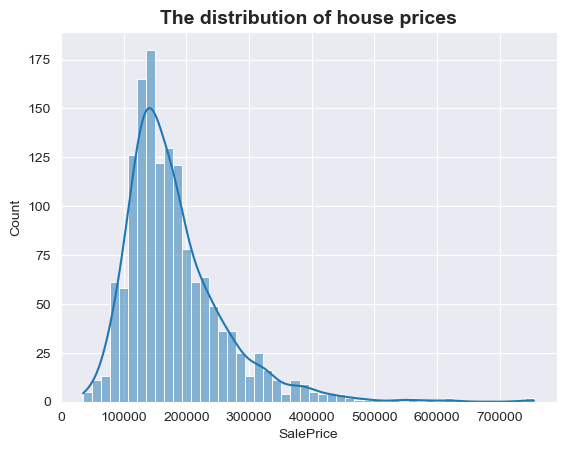

In [9]:
# Plotting the 'SalePrice' column distribution.

sns.histplot(data=train_df['SalePrice'], bins=50, kde=True)

plt.title('The distribution of house prices', fontsize=14, fontweight = 'bold')
plt.show()

## Checking if we have all columns in two dataframes

In [10]:
#features present in train data that are not present in test data

feature_train_not_test = [col for col in train_df.columns 
                          if col not in test_df.columns 
                          and col != 'SalePrice']

print("The number of features that are present in train but not test data is: ", len(feature_train_not_test))

The number of features that are present in train but not test data is:  0


In [11]:
#features present in test data that are not present in train data

feature_test_not_train = [col for col in test_df.columns if col not in train_df.columns]

print("The number of features that are present in test but not train data is: ", len(feature_test_not_train))

The number of features that are present in test but not train data is:  0


From the above results, we can understand that in both given datasets (train and test) we have the same features (same columns)!

## Data Cleaning

### Checking null values of the train df

In [19]:
# Checking columns with null values in Train DF

# Calculating the number of null values in train df
nulls_train = train_df.isna().sum()[train_df.isna().sum() > 0].reset_index().rename(columns={0:'#_of_nulls'})

# Calculating the perfentage of null values in train df
nulls_perc_train = ((train_df.isna().sum()[train_df.isna().sum() > 0] / train_df.shape[0]) * 100).reset_index().rename(columns={0:'%_of_nulls'})

# Creating the df of nulls
train_nulls = nulls_train.merge(nulls_perc_train, how='left', left_on = ['index'], right_on = ['index']).set_index('index')
train_nulls

,#_of_nulls,%_of_nulls
index,,
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740


### Checking null values of the test df

In [20]:
# Checking columns with null values in Test DF

# Calculating the number of null values in Test df
nulls_test = test_df.isna().sum()[test_df.isna().sum() > 0].reset_index().rename(columns={0:'#_of_nulls'})

# Calculating the perfentage of null values in Test df
nulls_perc_test = ((test_df.isna().sum()[test_df.isna().sum() > 0] / test_df.shape[0]) * 100).reset_index().rename(columns={0:'%_of_nulls'})

# Creating the df of nulls
test_nulls = nulls_test.merge(nulls_perc_test, how='left', left_on = ['index'], right_on = ['index']).set_index('index')
test_nulls

,#_of_nulls,%_of_nulls
index,,
MSZoning,4,0.274160
LotFrontage,227,15.558602
Alley,1352,92.666210
Utilities,2,0.137080
Exterior1st,1,0.068540
Exterior2nd,1,0.068540
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
BsmtQual,44,3.015764


As it is shown above, there are lots of null values in these datasets, we will clean and fill them before creating the model.

All the data will be cleaned based on column types and also by columns definitions, which can be found on <code>data_description.txt</code>, in **data** directory!

In [21]:
# Creating functions to fill null values 
# Based on column definition, null values will be filled diferentely

# Function for filling with mean
def fill_mean(df, column):
    """
    This function fills null values of a specific column 
    with the average value of that column
    """
    df[column].fillna(df[column].mean(), inplace=True)
    
# Function for filling with mode
def fill_mode(df, column):
    """
    This function fills null values of a specific column 
    with the mode value of that column
    """
    df[column].fillna(df[column].mode()[0], inplace=True)
    
# Function for filling with none
def fill_none(df, column):
    """
    This function fills null values of a specific column 
    with 'None'
    """
    df[column].fillna('None', inplace=True)
    
# Function for filling with zero
def fill_zero(df, column):
    """
    This function fills
    null values of a specific column 
    with zero
    """
    df[column].fillna(0.0, inplace=True)

### Filling null values of Train df

In [22]:
# Distinguishing columns to fill by different methods

train_fill_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PoolQC', 'Fence', 'MiscFeature']

train_fill_with_mean = ['LotFrontage']

train_fill_with_zero = ['MasVnrArea']

train_fill_with_mode = ['Electrical']

# GarageYrBlt will not be filled since houses that do not have garage, their built year is unknown
# Also GarageYrBlt will not be used to train the model

In [23]:
# Filling null values of targeted columns with none values
for i in train_fill_with_none:
    fill_none(train_df, i)
    
# Filling null values of targeted columns with mean values
for i in train_fill_with_mean:
    fill_mean(train_df, i)
    
# Filling null values of targeted columns with zero values
for i in train_fill_with_zero:
    fill_zero(train_df, i)
    
# Filling null values of targeted columns with mode values
for i in train_fill_with_mode:
    fill_mode(train_df, i)

### Filling null values of Test df

In [24]:
# Distinguishing columns to fill by different methods

test_fill_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PoolQC', 'Fence', 'MiscFeature']

test_fill_with_mean = ['LotFrontage']

test_fill_with_zero = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2', 
                       'BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
                      'BsmtHalfBath','GarageCars','GarageArea']

test_fill_with_mode = ['MSZoning','Utilities','Exterior1st','Exterior2nd',
                       'KitchenQual', 'Functional', 'SaleType']

# GarageYrBlt will not be filled since houses that do not have garage, their built year is unknown
# Also GarageYrBlt will not be used to train the model

In [25]:
# Filling null values of targeted columns with none values
for i in test_fill_with_none:
    fill_none(test_df, i)
    
# Filling null values of targeted columns with mean values
for i in test_fill_with_mean:
    fill_mean(test_df, i)
    
# Filling null values of targeted columns with zero values
for i in test_fill_with_zero:
    fill_zero(test_df, i)
    
# Filling null values of targeted columns with mode values
for i in test_fill_with_mode:
    fill_mode(test_df, i)

## Data Exploration & Preprocessing

### Boxplot of numerical features

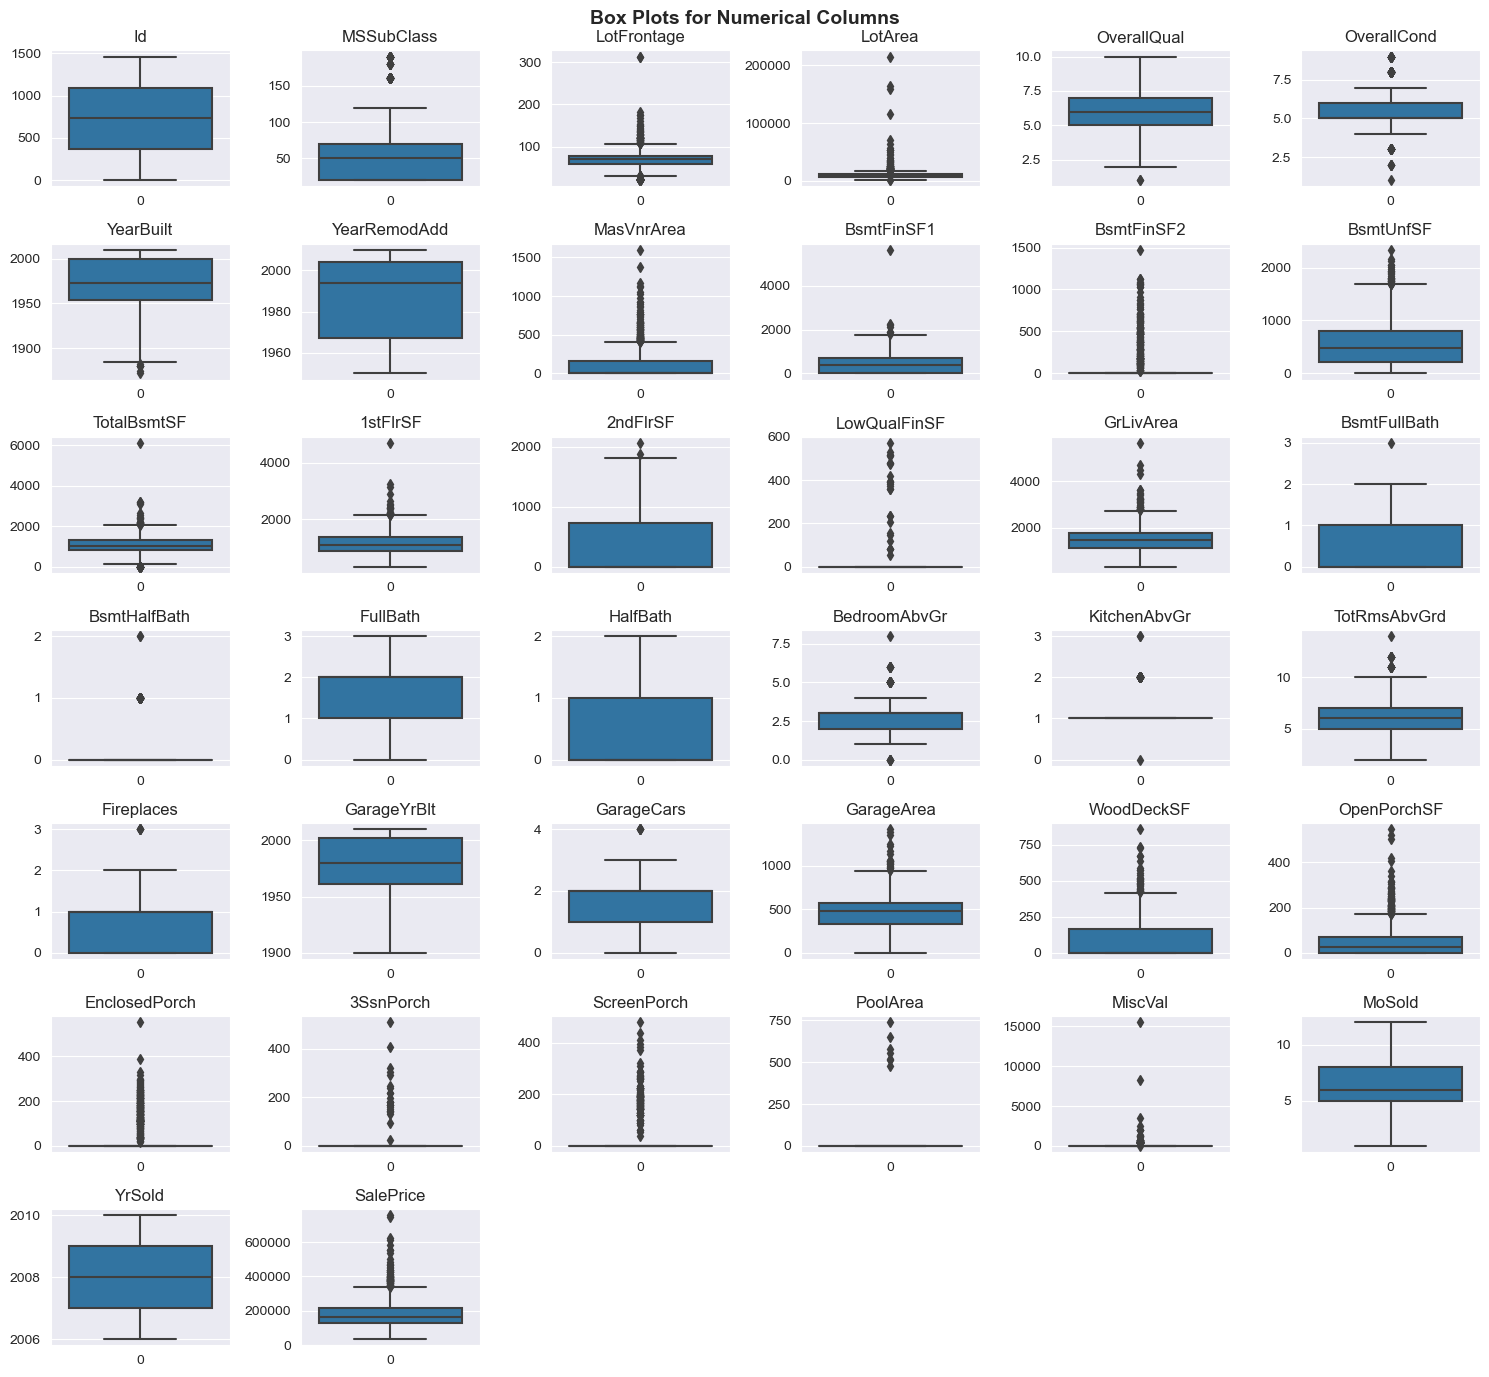

In [26]:
# List of numerical columns
numerical_columns = train_df.select_dtypes(exclude=['object']).columns

# Calculateing the number of rows and columns needed for the subplot grid
num_plots = len(numerical_columns)
num_rows = math.ceil(num_plots / 6)
num_cols = min(num_plots, 6)

# Creatingsubplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))

# Flattening the axes array if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Looping through the numerical columns and create boxplots
for i, col in enumerate(numerical_columns):
    sns.boxplot(data=train_df[col],  ax=axes[i])
    axes[i].set_title(col)

# Removeing empty subplots if there are fewer than 6 columns
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adding a title to the main figure
fig.suptitle("Box Plots for Numerical Columns", fontsize=14, fontweight='bold')   
    
# Adjusting layout
plt.tight_layout()
plt.show()

From the above figure it can be observed that are outliers in the data. For the specific problem that we have, we will not remove outliers outliers as the chances is it might destroy some important data.

### Scatterplot of categorical vs "SalePrice"

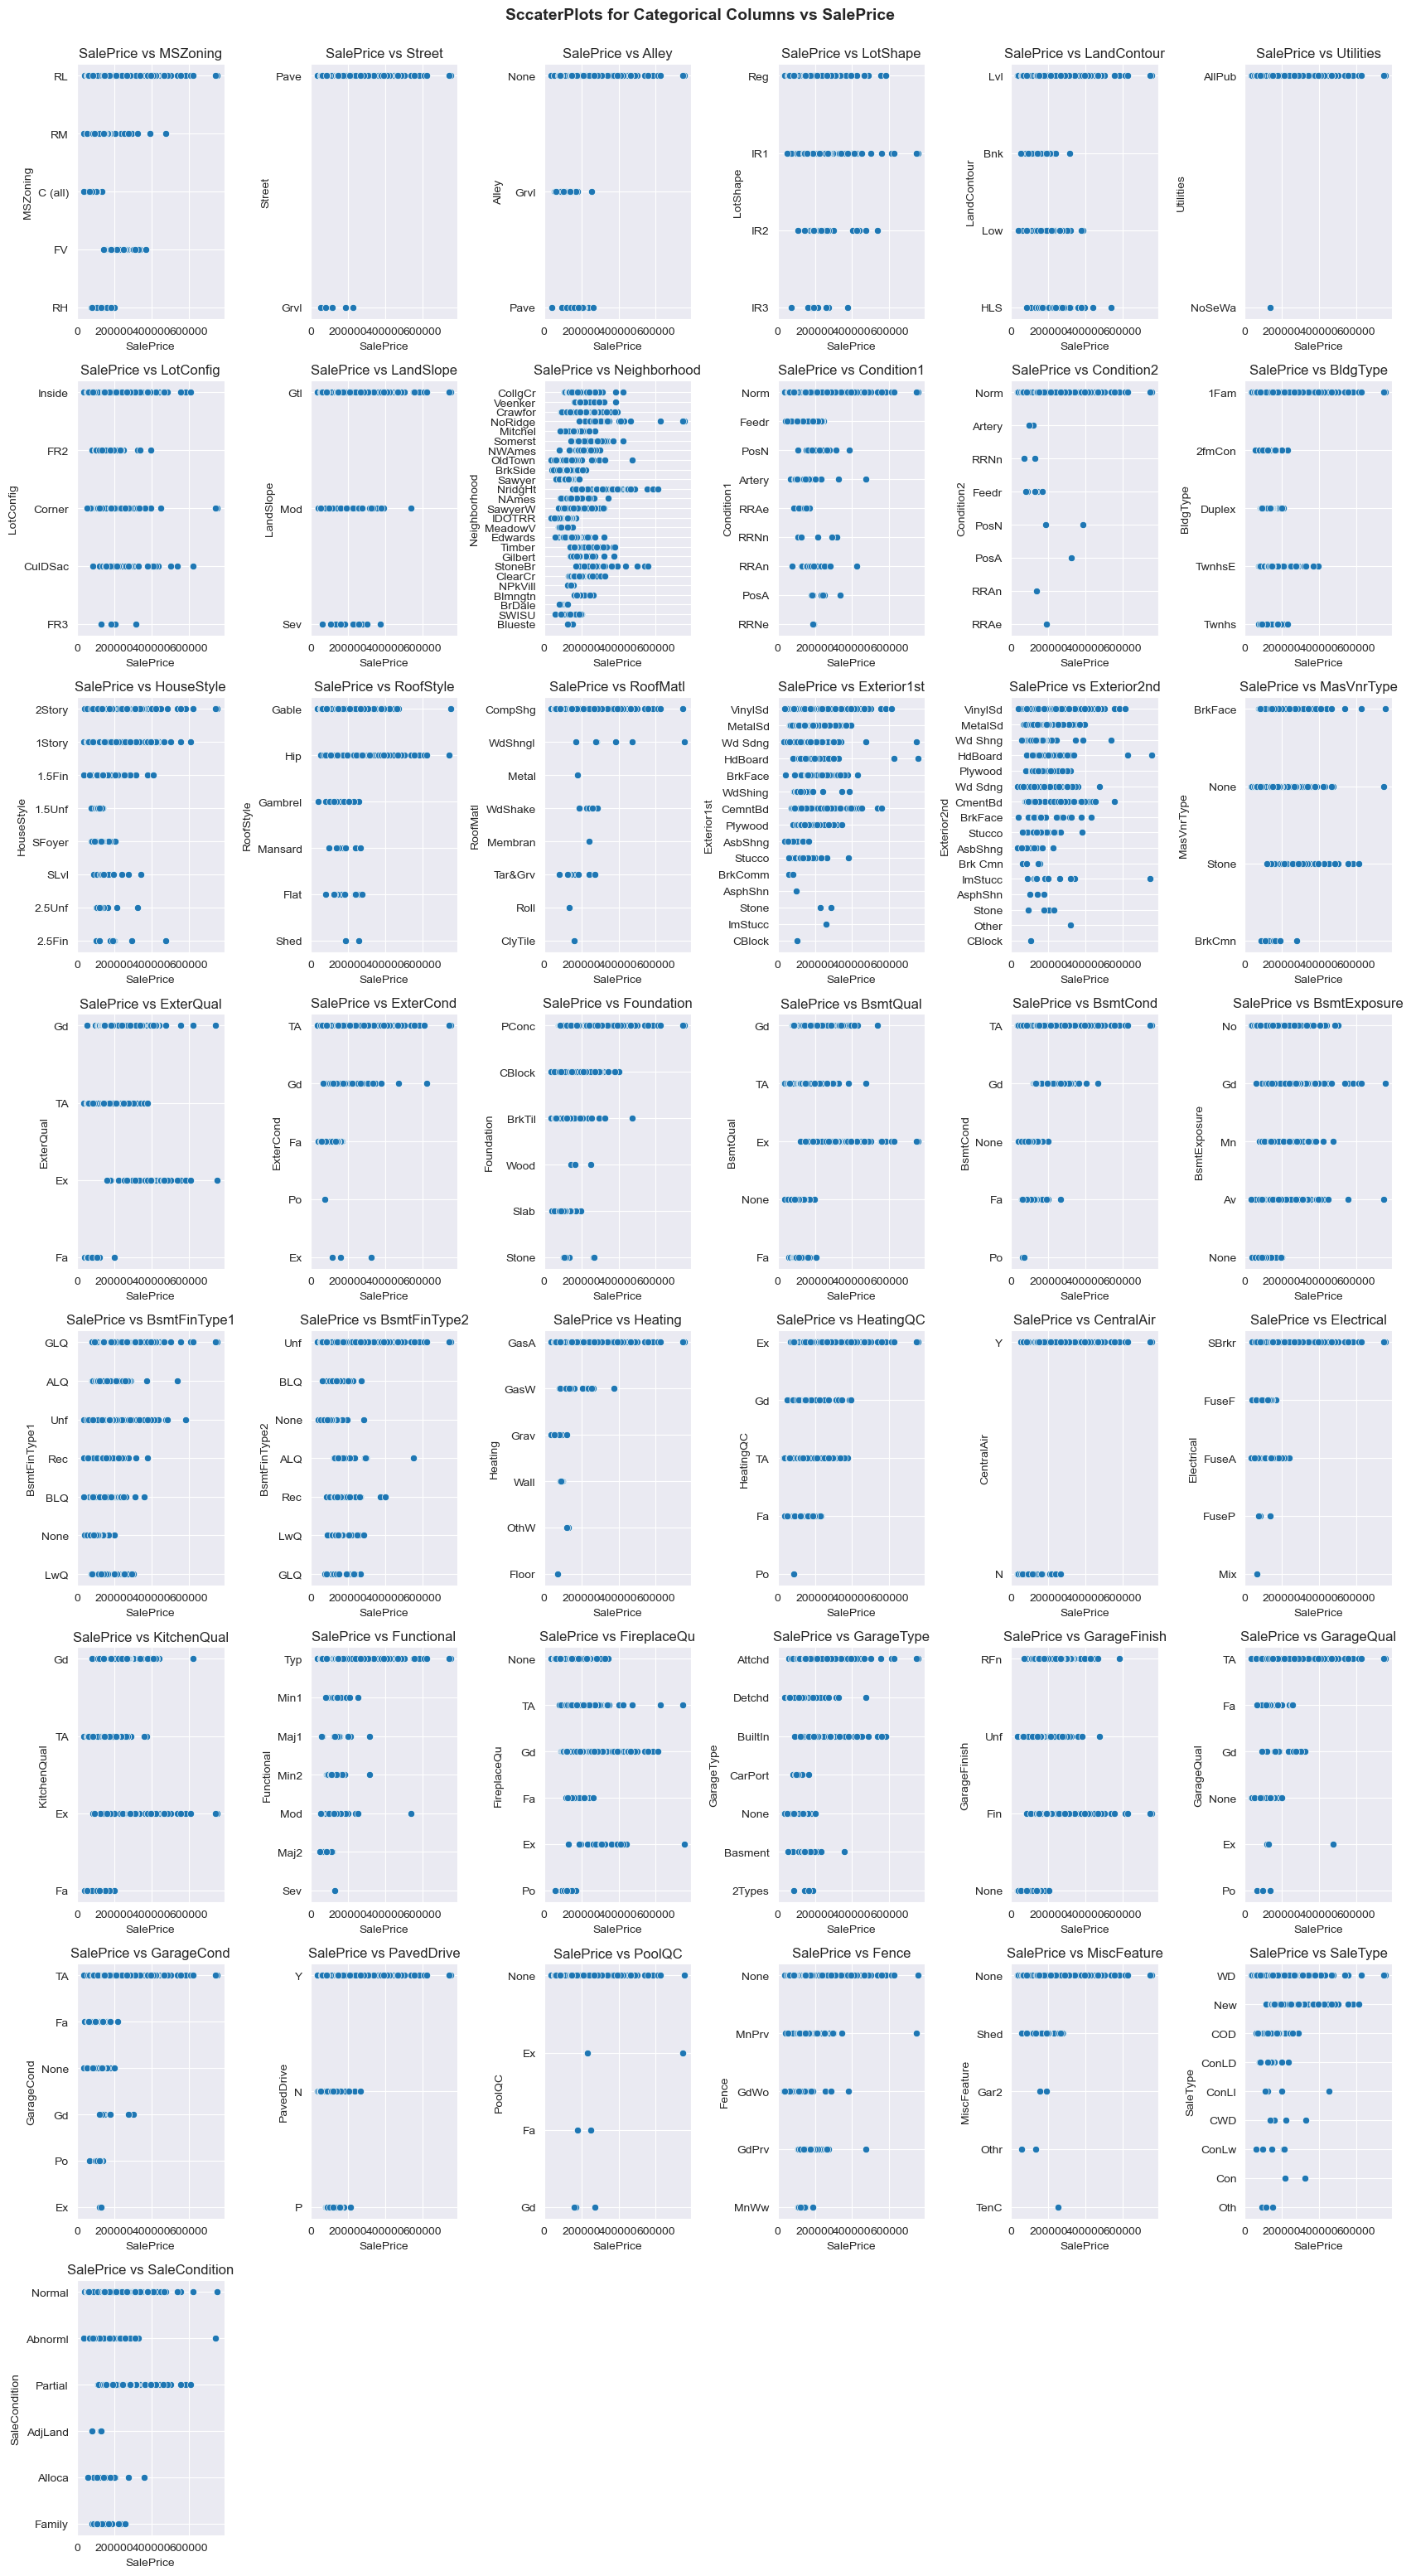

In [27]:
# List of categorical columns
object_columns = train_df.select_dtypes(include=['object']).columns

# Calculateing the number of rows and columns needed for the subplot grid
num_plots = len(object_columns)
num_rows = math.ceil(num_plots / 6)
num_cols = min(num_plots, 6)

# Createing subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, 4 * num_rows))

# Flattening the axes array if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Looping through the categorical columns and create scatter plots
for i, col in enumerate(object_columns):
    sns.scatterplot(data=train_df, x='SalePrice', y=col, ax=axes[i])
    axes[i].set_title(f'SalePrice vs {col}')

# Removeing empty subplots if there are fewer than 6 columns
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adding a title to the main figure
fig.suptitle("SccaterPlots for Categorical Columns vs SalePrice", fontsize=14, fontweight='bold') 

# Adjusting layout
plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()

From the above plots, it can be observet that there are some categorical features that the SalePrice is highly correlated. For example, the price of the houses is different for different neighborhood, quality, condition style and so on. From this it can be infered that we should use our helpful categorical features as well, while training the model

### Heatmap of pearsons correlation between the features

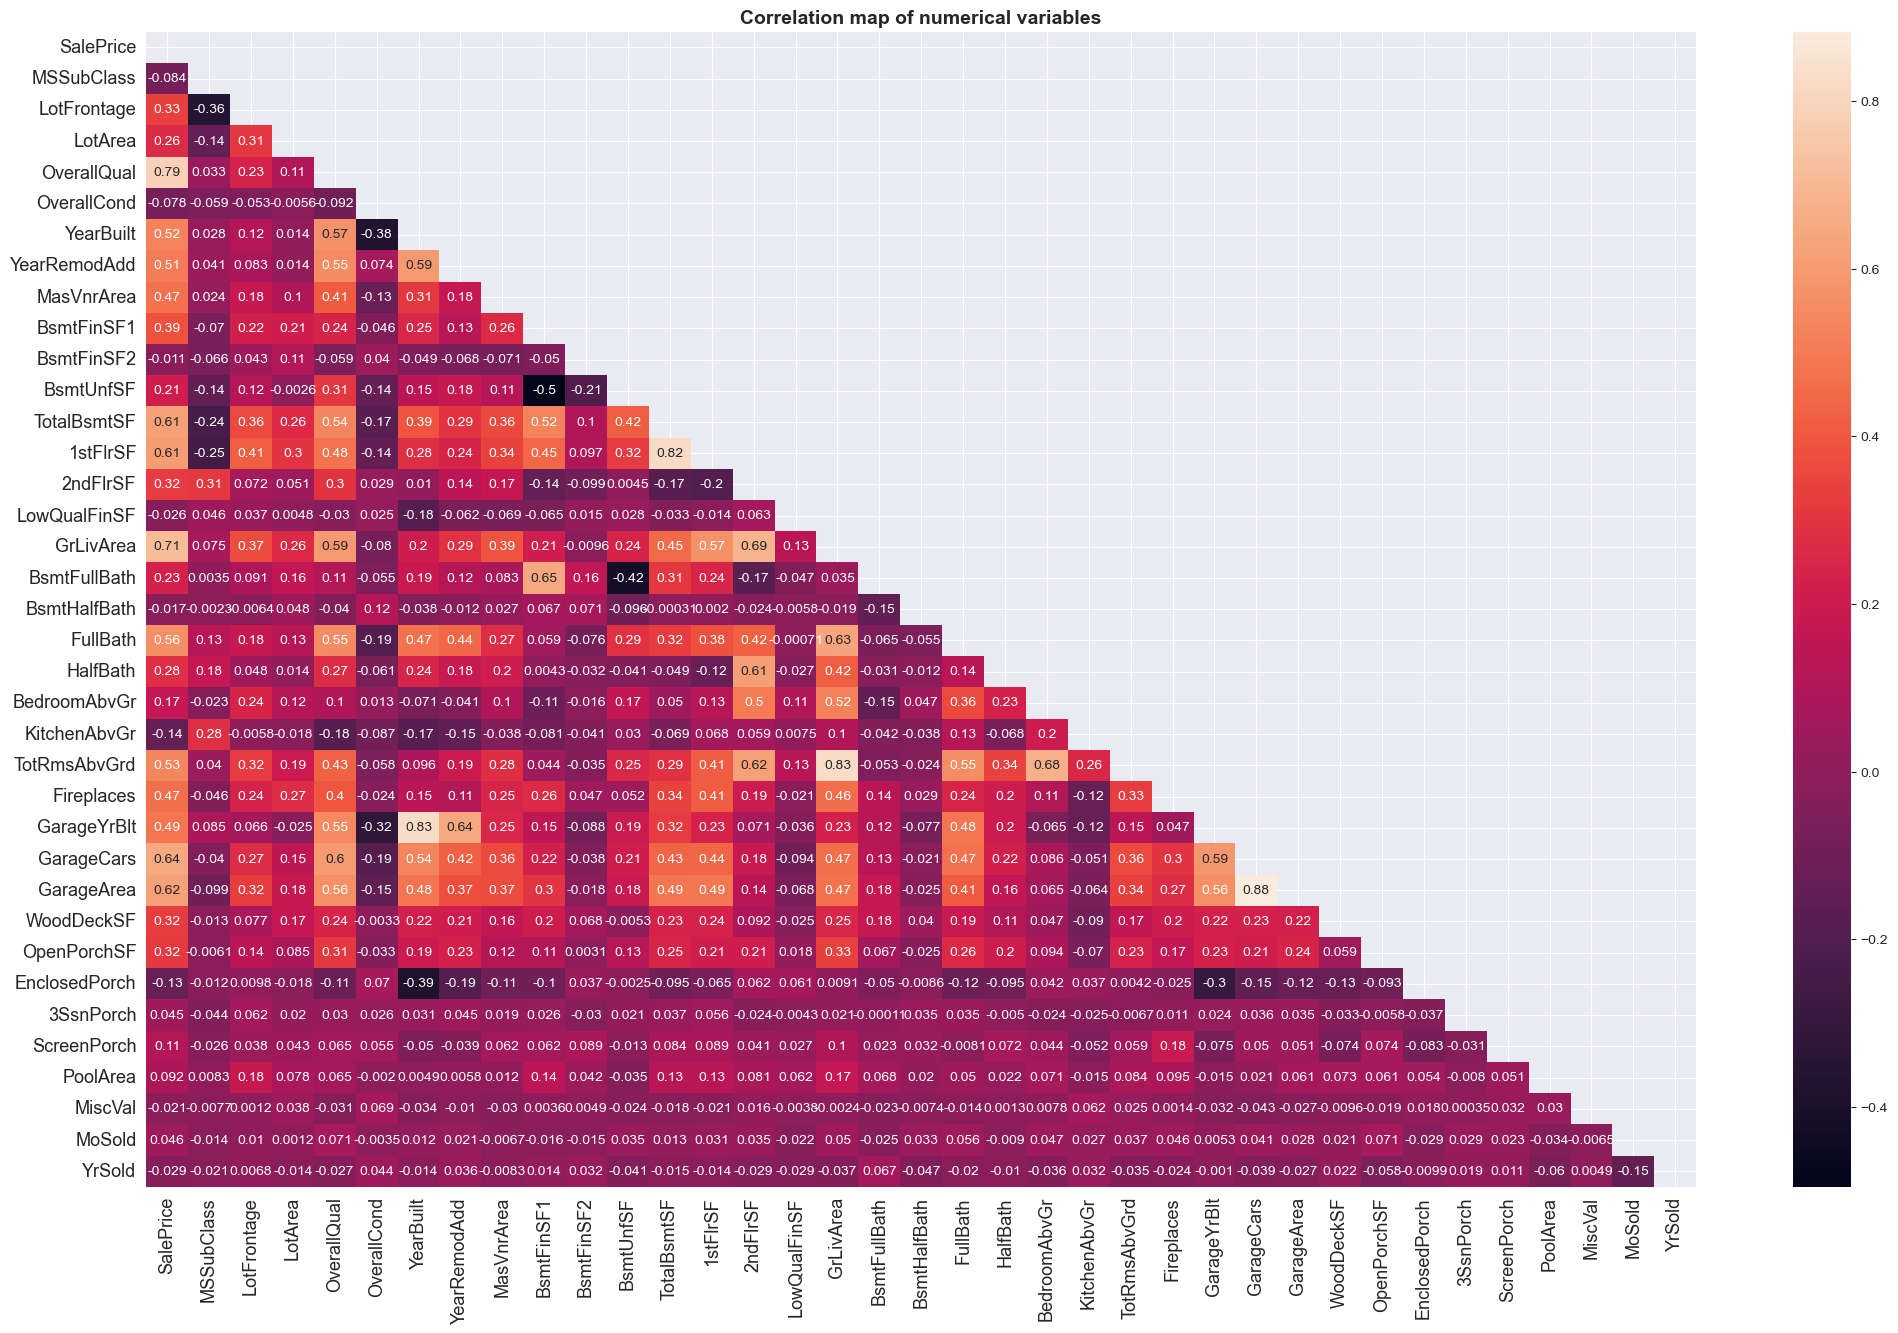

In [28]:
# Plotting the heatmap of correlations between features

fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(data=train_df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']].corr(), annot=True, mask = np.triu(np.ones_like(train_df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']].corr(), dtype=bool)))

plt.title('Correlation map of numerical variables', fontsize=14, fontweight = 'bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### Data preprocessing

In [29]:
def preprocess_data(df):
    """
    This function is created to preprocess the df
    and use it for training
    """
    
    # Copying the old df
    df_new = df.copy()
    
    # Feature Engineering of some columns
    df_new['HouseAge'] = df_new['YrSold'] - df_new['YearBuilt']
    df_new['TotalSF'] = df_new['TotalBsmtSF'] + df_new['1stFlrSF'] + df_new['2ndFlrSF']
    df_new['TotalBath'] = df_new['FullBath'] + df_new['HalfBath'] + df_new['BsmtFullBath'] + df_new['BsmtHalfBath']
    df_new['TotalPorchSF'] = df_new['OpenPorchSF'] + df_new['EnclosedPorch'] + df_new['3SsnPorch'] + df_new['ScreenPorch']
    
    # Dropping unesecary features, analyzed from the notebook
    df_new.drop(['Street', 'Alley', 'LotShape', 'LandContour',
    'YearRemodAdd', 'MasVnrType', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath',
    'BsmtFullBath', 'BsmtHalfBath',
    'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'PoolArea',
    'MiscVal',
    'GarageYrBlt', 
    'FireplaceQu', 'Fireplaces'], axis=1, inplace=True)
    
    return df_new

#### Preprocessing and copying preprocessed df

In [30]:
# Preprocessing the train df
train_df_preprocessed = preprocess_data(train_df)

# Preprocessing the test df
test_df_preprocessed = preprocess_data(test_df)

#### Encoding categorical Features

In [32]:
# Getting object columns from train_df
# Since we have same columns or features in both the train and test df, the below list will be used for both

object_columns = train_df_preprocessed.select_dtypes(include=['object']).columns

In [33]:
# Encoding categorical features of train df using LabelEncoder()
# """ LabelEncoder is a class provided by the scikit-learn library in Python, specifically in the sklearn.preprocessing module. 
# It is used for encoding categorical (textual) labels into numerical format."""

for i in object_columns:
    le = LabelEncoder()
    train_df_preprocessed[i] = le.fit_transform(train_df_preprocessed[i])

In [34]:
# Encoding categorical features of test df using LabelEncoder()
# """ LabelEncoder is a class provided by the scikit-learn library in Python, specifically in the sklearn.preprocessing module. 
# It is used for encoding categorical (textual) labels into numerical format."""

for i in object_columns:
    le = LabelEncoder()
    test_df_preprocessed[i] = le.fit_transform(test_df_preprocessed[i])

## Creating the Xgboost Model

In [35]:
# Defining independed and depended variables

X = train_df_preprocessed.drop(['Id', 'SalePrice'], axis=1)

Y = train_df_preprocessed['SalePrice']

# Using train_test_split to split data into training and testing parts
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0) #0.2

In [36]:
# Defineing the parameter grid to use for grid search

param_grid = {
    'n_estimators': [5000, 10000],
    'max_depth': [4],
    'learning_rate': [0.01, 0.02],
    'colsample_bytree': [0.5],
    'subsample': [0.5],
    'min_child_weight': [2],
}

# Createing an XGBRegressor instance
regressor = xgb.XGBRegressor(booster='gbtree', early_stopping_rounds=500, eval_metric='rmsle')

# Creating GridSearchCV instance
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fitting the model to the data
grid_search.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=500)

# Printing the best parameters and corresponding performance
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[0]	validation_0-rmsle:0.40686	validation_1-rmsle:0.39692
[500]	validation_0-rmsle:0.11472	validation_1-rmsle:0.13297
[1000]	validation_0-rmsle:0.09928	validation_1-rmsle:0.13096
[1500]	validation_0-rmsle:0.09325	validation_1-rmsle:0.13091
[1707]	validation_0-rmsle:0.09128	validation_1-rmsle:0.13115
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=5000, subsample=0.5; total time=   3.1s
[0]	validation_0-rmsle:0.40351	validation_1-rmsle:0.39393
[500]	validation_0-rmsle:0.11043	validation_1-rmsle:0.12922
[1000]	validation_0-rmsle:0.09557	validation_1-rmsle:0.12540
[1500]	validation_0-rmsle:0.08880	validation_1-rmsle:0.12351
[2000]	validation_0-rmsle:0.08442	validation_1-rmsle:0.12313
[2500]	validation_0-rmsle:0.08131	validation_1-rmsle:0.12294
[3000]	validation_0-rmsle:0.07960	validation_1-rmsle:0.12291
[3055]	validation_0-rmsle:0.07944	validation_1-rmsle:0.12286
[CV] END colsample

In [37]:
# Fitting the xgboost model with best parameters from grid searchcv
regressor = xgb.XGBRegressor(booster = 'gbtree',
                             colsample_bytree = 0.5,
                             n_estimators = 5000,
                             min_child_weight = 2,
                             subsample = 0.5,
                             early_stopping_rounds=500,
                             #objective = 'reg:linear',
                             max_depth=4,
                             eval_metric='rmsle',
                             learning_rate = 0.02)

# Fitting the xgboost model
regressor.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 500)

[0]	validation_0-rmsle:0.40450	validation_1-rmsle:0.39452
[500]	validation_0-rmsle:0.08181	validation_1-rmsle:0.12751
[1000]	validation_0-rmsle:0.05835	validation_1-rmsle:0.12569
[1500]	validation_0-rmsle:0.04040	validation_1-rmsle:0.12585
[1730]	validation_0-rmsle:0.03459	validation_1-rmsle:0.12620


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
predictions_test = regressor.predict(X_test)

#from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt(mean_squared_log_error(Y_test, predictions_test))
print("The score is %.5f" % RMSLE)

The score is 0.12538


## Predicting the test_df data

In [39]:
# Predicting the house price of the test_df

y_predict = regressor.predict(test_df_preprocessed.drop(['Id'], axis=1))

In [40]:
# Creating a df for the predicted prices
predictions_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_predict})

# Storing the created df to a csv file
predictions_df.to_csv('../stored results/predicted_testdf_prices.csv', index=False)
predictions_df.head(10)

,Id,SalePrice
0,1461,128913.039062
1,1462,168803.468750
2,1463,181958.515625
3,1464,189284.312500
4,1465,184993.531250
5,1466,168725.687500
6,1467,170317.140625
7,1468,164644.453125
8,1469,182953.890625
9,1470,133784.312500
